<a href="https://colab.research.google.com/github/jvoliveira/Deep-Learning/blob/main/convolutional_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**PA3: Convolutional Neural Networks**

### **Introduction**
In this programming assignment, you will implement a Convolutional Neural Network (CNN) in Python with the Pytorch library to classify images of handwritten digits. As part of this process, you will write your own custom Convolution and MaxPooling layers. You will then use these layers to build a LeNet-5 network. You will train your LeNet-5 with the classic MNIST dataset, which is large enough to justify training with Mini-batch gradient descent. At the end of this assignment, you will see how the LeNet-5 can achieve high accuracy on handwritten digit image classication. After that, you will tweak this model to apply it to a different image classification problem.

### **Objective**

The main objective of this project is to practice implementing CNNs in PyTorch, including dataset loading, implementation of custom layers, training with gradient descent, and evaluation of trained models.

### **Instructions**

Differently than the previous assignments, this time you won't be told exactly where to write your code, but will be given class and function signatures that you can implement the way you want. However, you will still will have test cells with expected results, so you can check if your solution is on the right track.

### **Part 0: Import libraries**

Unlike the other practical assignments, in P4 you will not import `numpy`, but rather `torch`, to load PyTorch functionalities. You will also load the following auxiliary libraries:

- **torch.utils.data.DataLoader**: class for creating a data loader based on custom datasets.
- **torchvision.datasets**: built-in computer vision datasets.
- **torchvision.transforms**: set of functions for transforming images.
- **matplotlib**: main library for plotting graphs in Python.

In [ ]:
import torch
import time
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

### **Part 1: Load the MNIST dataset**

Implement the `load_mnist` function to load the MNIST dataset with the `datasets.MNIST()` function from the `torchvision.datasets` module. This function will return dataset objects. You will need to create one of these objects for the training set and another for the test set. You can use `transforms.ToTensor()` and `transforms.Normalize()` to convert the images to tensors and normalize them, respectively. Apply these transformatins to both sets. When calling the `datasets.MNIST` function you will have to pass these two transformations into a single argument. You can use `transforms.Compose` to compose these two transformations into a single list of transformations.

After loading the train and test sets, create the `Dataloader` for each one of them. These dataloaders help you generating mini-batches at training time. Note the `batch_size` is an argument of the `load_mnist` funtion. Use this argument to create the dataloaders. Make sure to set `shuffle` parameters of the training dataloader to true, because we want to shuffle the data before every epoch of the mini-batch gradient descent. You don't need to shuffle the test set. Your function has to return two dataloders, one for the training set and another for the test set.

In [ ]:
def load_mnist(batch_size=32):
    # Create transformers
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307), (0.3081))
    ])
    # Load Dataset
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    # Create dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [ ]:
# Set random seed
torch.manual_seed(42)

# Load the MNIST dataset
train_loader, test_loader = load_mnist(batch_size=16)

# Print number of training and testing example
print(f"Number of training examples: {len(train_loader.dataset)}")
print(f"Number of testing examples: {len(test_loader.dataset)}")

# Get a single batch of data
data, target = next(iter(test_loader))

# Select an index to view an image
index = 10

# Plot part image
print(f"Sample pixels of image [{index}]: {data[index].numpy().squeeze()[10][:10]}")

Number of training examples: 60000
Number of testing examples: 10000
Sample pixels of image [10]: [-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
 -0.42421296 -0.42421296  2.0450644   2.8087585 ]


**Expected result:**
<table style="width:50%">
  <tr>
    <td>Number of training examples</td>
    <td>60000</td>
  </tr>
  <tr>
    <td>Number of testing examples</td>
    <td>10000</td>
  </tr>
    <tr>
    <td>Sample pixels of image [10]</td>
    <td>[-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
 -0.42421296 -0.42421296  2.0450644   2.8087585 ]</td>
  </tr>
</table>

## **Part 2: Convolutional Neural Network**

In Pytorch, neural network layers and complete models are implemented extending `torch.nn.Module` class. There are two main methods you need to implement when creating a new model: `__init__` to initialize the attributes of your model and `forward`, which will perform the forward pass of your model.

#### **2.1 A first convolution layer**

The first layer you will implement is the Convolution Layer with stride and padding. The main attributes you need to consider are the number of input channels `in_channels`, the number of output channels `out_channels`, the kernel size `kernel_size`, stride size `stride` and padding size `padding`.

1. `__init__`: Create the weights (filters) and a bias vector using the `torch.nn.Parameter` function. Your filter tensor should have size `(out_channels, in_channels, kernel_size, kernel_size)`. You can initialize the weights with the `torch.randn` function. Also save the paramteres values using attributes to use them in `forward`.

2. `forward(x)`: perform the forward pass on a mini-batch `x` of size `(batch_size, in_channels, in_height, in_width)`. This operation has to support padding (see `torch.nn.functional.pad`) and strides of any sizes. For this, you will have to compute the output width $w_o$ and $h_o$ using the formula we saw in class:

$
\begin{align}
w_o = \frac{w_i + 2p - f}{s} + 1 \\
h_o = \frac{h_i + 2p - f}{s} + 1
\end{align}
$

where $w_i$ is the input image width, $h_i$ is the input image height, $p$ is the padding size, $f$ is the filter size and $s$ is the stride size.

With $w_o$ and $h_o$ computed, you can implement the convolution with 4 for loops: 1 over the batch size, 1 over the number of filters, 1 over the output height and 1 over the output width. Make sure your output tensor is of size `(batch_size, out_channels, out_height, out_width)`




In [ ]:
class CustomConv2d(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        """
        Initialize weights, bias, and hyperparamtenrs of the convolutional layer

        Args:
            in_channels (int): number of input channels
            out_channels (int): number of output channels
            kernel_size (int): size of the kernel
            stride (int): stride size
            padding (int): padding size
        """
        super(CustomConv2d, self).__init__()

        # Init attributes
        self.padding = padding
        self.kernel_size = kernel_size
        self.stride = stride
        self.out_channels = out_channels
        self.in_channels = in_channels

        # Init Weights/Filters
        self.weights = torch.nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size))
        # Init Bias Vector
        self.bias = torch.nn.Parameter(torch.randn(out_channels))

    def forward(self, x):
        """
        Perform the forward pass of a convolution layer on a mini-batch x

        Args:
            x (torch.Tensor): mini-batch of images of size (batch_size, in_channels, in_height, in_width)

        Returns:
            torch.Tensor: output of the convolutional layer of size (batch_size, out_channels, out_height, out_width)
        """
        # Apply padding
        x = torch.nn.functional.pad(x, (self.padding, self.padding, self.padding, self.padding))

        # Get new values after padding
        batch_size, in_channels, in_height, in_width = x.shape

        # Define the output sizes
        out_height = (in_height - self.kernel_size) // self.stride + 1
        out_width = (in_width - self.kernel_size) // self.stride + 1

        # Create tensor with zeros
        output = torch.zeros((batch_size, self.out_channels, out_height, out_width))

        # Manual Convolution
        for b in range(0, batch_size):
            for oc in range(0, self.out_channels):
                for i in range(0, out_height):
                    for j in range(0, out_width):
                        # Get region of interest
                        region = x[b, :, i * self.stride : i * self.stride + self.kernel_size, j * self.stride : j * self.stride + self.kernel_size]
                        # Doing the Convolution
                        output[b, oc, i, j] = torch.sum(region * self.weights[oc]) + self.bias[oc]

        return output


In [ ]:
# Set random seed
torch.manual_seed(42)

# Create an instance of your custom convolution layer
custom_conv = CustomConv2d(in_channels=1, out_channels=6, kernel_size=5)

# Show output for a single example of the dataset
first_batch = next(iter(test_loader))[0]

# Pick one image in the mini-batch
first_image = first_batch[0]
output_custom_conv = custom_conv(first_image.unsqueeze(0))

# Output Sample
print("Output shape:", output_custom_conv.size())
print("Output sample:", output_custom_conv[:,:,0,0])

Output shape: torch.Size([1, 6, 24, 24])
Output sample: tensor([[-0.3627,  2.7504, -2.1521,  1.8907, -2.4571,  1.1121]],
       grad_fn=<SelectBackward0>)


**Expected result:**
<table style="width:50%">
  <tr>
    <td>Output size</td>
    <td>[1, 6, 24, 24]</td>
  </tr>
  <tr>
    <td>Output sample</td>
    <td>[[-0.3627,  2.7504, -2.1521,  1.8907, -2.4571,  1.1121]]</td>
  </tr>
</table>

In [ ]:
# Set random seed
torch.manual_seed(42)

# Create an instance of your custom convolution layer
custom_conv = CustomConv2d(in_channels=1, out_channels=6, kernel_size=5)

# Compare with pytorch's conv2d Layer
pytorch_conv = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)

# Forward pass of both networks
first_batch = next(iter(test_loader))[0]

# Measure time
t1 = time.perf_counter()
output_custom_conv = custom_conv(first_batch)
t2 = time.perf_counter()

print(f"Time taken by custom conv: {t2-t1} seconds")

t1 = time.perf_counter()
output_pytorch_conv = pytorch_conv(first_batch)
t2 = time.perf_counter()

print(f"Time taken by pytorch conv: {t2-t1} seconds")

Time taken by custom conv: 4.312109540001984 seconds
Time taken by pytorch conv: 0.008386703000724083 seconds


**Expected result:**
<table style="width:50%">
  <tr>
    <td>Time taken by custom conv</td>
    <td>3.8795 seconds</td>
  </tr>
  <tr>
    <td>Time taken by pytorch conv</td>
    <td>0.0022 seconds</td>
  </tr>
</table>

#### **2.2 Vectorizing the convolution operation**

As showed in the experiment above, implementing convolutions with 4 for loops is too slow. A single mini-batch of size 16 is taking more than 3 seconds to execute, so training on the entire MNIST dataset would take approximately $15 * (60000/3) = 20000\ seconds = 5.5\ hours$. This is a very long time considering the MNIST images are only 28x28 pixels large. We can reduce this time considerably implementing the convolution operation with vectorization (as the Pytorch implementation). To do that, we need to first generate the chunks for each convolution step and then multiply them by the kernel in parallalel.  In the next cell, change your `CustomConv2d` cell to use vectorization. You can use Pytorch's `torch.nn.functional.unfold` function to generate the chuncks for each concolution step. The `view` method of tensors might useful here too, to reshape the tensors.


In [ ]:
class CustomConv2d(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        """
        Initialize weights, bias, and hyperparamtenrs of the convolutional layer

        Args:
            in_channels (int): number of input channels
            out_channels (int): number of output channels
            kernel_size (int): size of the kernel
            stride (int): stride size
            padding (int): padding size
        """
        super(CustomConv2d, self).__init__()

        # Init attributes
        self.padding = padding
        self.kernel_size = kernel_size
        self.stride = stride
        self.out_channels = out_channels

        # Init Weights/Filters
        self.weights = torch.nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size))
        # Init Bias Vector
        self.bias = torch.nn.Parameter(torch.randn(out_channels))

    def forward(self, x):
        """
        Perform the forward pass of a convolution layer on a mini-batch x

        Args:
            x (torch.Tensor): mini-batch of images of size (batch_size, in_channels, in_height, in_width)

        Returns:
            torch.Tensor: output of the convolutional layer of size (batch_size, out_channels, out_height, out_width)
        """
        # Apply padding
        x = torch.nn.functional.pad(x, (self.padding, self.padding, self.padding, self.padding))

        # Get new values after padding
        batch_size, in_channels, in_height, in_width = x.shape

        # Define the output sizes
        out_height = (in_height - self.kernel_size) // self.stride + 1
        out_width = (in_width - self.kernel_size) // self.stride + 1

        # Generate chunks
        unfolded = torch.nn.functional.unfold(x, kernel_size=self.kernel_size, stride=self.stride)

        # Transpose
        weights_reshaped = self.weights.view(self.out_channels, -1)

        # Multiply
        output = weights_reshaped @ unfolded

        # Add bias
        output += self.bias.view(1, -1, 1)

        # Adjust output
        output = output.view(batch_size, self.out_channels, out_height, out_width)

        return output

In [ ]:
# Set random seed
torch.manual_seed(42)

# Create an instance of your custom convolution layer
custom_conv = CustomConv2d(in_channels=1, out_channels=6, kernel_size=5)

# Show output for a single example of the dataset
first_batch = next(iter(test_loader))[0]

# Pick one image in the mini-batch
first_image = first_batch[0]
output_custom_conv = custom_conv(first_image.unsqueeze(0))

# Output sample
print("Output shape:", output_custom_conv.size())
print("Output sample:", output_custom_conv[:,:,0,0])

Output shape: torch.Size([1, 6, 24, 24])
Output sample: tensor([[-0.3627,  2.7504, -2.1521,  1.8907, -2.4571,  1.1121]],
       grad_fn=<SelectBackward0>)


**Expected result:**
<table style="width:50%">
  <tr>
    <td>Output size</td>
    <td>[1, 6, 24, 24]</td>
  </tr>
  <tr>
    <td>Sample output</td>
    <td>[[-0.3627,  2.7504, -2.1521,  1.8907, -2.4571,  1.1121]]</td>
  </tr>
</table>

In [ ]:
# Set random seed
torch.manual_seed(42)

# Create an instance of your custom convolution layer
custom_conv = CustomConv2d(in_channels=1, out_channels=6, kernel_size=5)

# Compare with pytorch's conv2d Layer
pytorch_conv = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)

# Forward pass of both networks
first_batch = next(iter(test_loader))[0]

# Measure time
t1 = time.perf_counter()
output_custom_conv = custom_conv(first_batch)
t2 = time.perf_counter()

print(f"Time taken by custom conv: {t2-t1} seconds")

t1 = time.perf_counter()
output_pytorch_conv = pytorch_conv(first_batch)
t2 = time.perf_counter()

print(f"Time taken by pytorch conv: {t2-t1} seconds")

Time taken by custom conv: 0.005687550001312047 seconds
Time taken by pytorch conv: 0.0012292809988139197 seconds


**Expected result:**
<table style="width:50%">
  <tr>
    <td>Time taken by custom conv</td>
    <td>0.0031 seconds</td>
  </tr>
  <tr>
    <td>Time taken by pytorch conv</td>
    <td>0.0008 seconds</td>
  </tr>
</table>

#### **2.3 MaxPool Layer**

Now that you have a vectorized convolution layer, follow the same idea to implement a custom max pool layer. Remeber that this layer does not have weights. You can use the `torch.max` function to pool out the maximum values after generating the convolution image chuncks.


In [ ]:
class CustomMaxPool2d(torch.nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        """
        Initialize the hyperparameters of the max pooling layer

        Args:
            kernel_size (int): size of the kernel
            stride (int): stride size
            padding (int): padding size
        """
        super(CustomMaxPool2d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        """
        Perform the max pooling operation on a mini-batch x

        Args:
            x (torch.Tensor): mini-batch of images of size (batch_size, in_channels, in_height, in_width)

        Returns:
            torch.Tensor: output of the max pooling layer of size (batch_size, out_channels, out_height, out_width)
        """
        # Apply padding to the input
        x = torch.nn.functional.pad(x, (self.padding, self.padding, self.padding, self.padding))

        # Get the dimensions of the input
        batch_size, channels, in_height, in_width = x.shape

        # Calculate output dimensions
        out_height = (in_height - self.kernel_size) // self.stride + 1
        out_width = (in_width - self.kernel_size) // self.stride + 1

        # Use unfold to get the chunks for pooling
        unfolded = torch.nn.functional.unfold(x, kernel_size=self.kernel_size, stride=self.stride)

        # Reshape unfolded tensor to (batch_size, channels, kernel_size*kernel_size, out_height*out_width)
        unfolded = unfolded.view(batch_size, channels, self.kernel_size * self.kernel_size, -1)

        # Use max to get the maximum values from the unfolded tensor
        pooled, _ = torch.max(unfolded, dim=2)

        # Reshape pooled tensor to (batch_size, channels, out_height, out_width)
        output = pooled.view(batch_size, channels, out_height, out_width)

        return output

In [ ]:
# Set random seed
torch.manual_seed(42)

# Create an instance of your custom max pooling layer
custom_maxpool = CustomMaxPool2d(kernel_size=2, stride=2)

# Pass the output of the convolutional layer through the pooling layer
output_custom_maxpool = custom_maxpool(output_custom_conv)

# Output sample
print("Output shape:", output_custom_maxpool.size())
print("Output sample:", output_custom_maxpool[0,:,0,0])

Output shape: torch.Size([16, 6, 12, 12])
Output sample: tensor([-0.3627,  2.7504, -2.1521,  1.8907, -2.4571,  1.1121],
       grad_fn=<SelectBackward0>)


**Expected result:**
<table style="width:50%">
  <tr>
    <td>Output size</td>
    <td>[16, 6, 12, 12]</td>
  </tr>
  <tr>
    <td>Sample output</td>
    <td>[[-0.3627,  2.7504, -2.1521,  1.8907, -2.4571,  1.1121]]</td>
  </tr>
</table>

#### **2.4 LeNet-5**

In this section, you will use your custom convolution and pooling layers to implement the variation of LeNet-5 we saw in class (see image below). Similarly to implementing layers, in Pytorch you can create entire models by extending the `torch.nn.module`. You just have to instantiate your layers as attributes in the `__init__` function and implement the full forward pass in the `forward(x)` function. In the forward function, you will pass the input $x$ though the sequence of layers following the specification of the network, which will produce a final prediction $\hat{y}$ at the end. Your forward function has to return this prection $\hat{y}$. Use the pytorch `torch.nn.functional.relu` funtion to add the ReLU non-linearity to your convolutional hidden layers.

**In Pytorch, it is good practice to not add the softmax (or logistic)classification head as part of the model, since Pytorch can optimize training by computing the softmax/logistic activation as part of the loss function.**

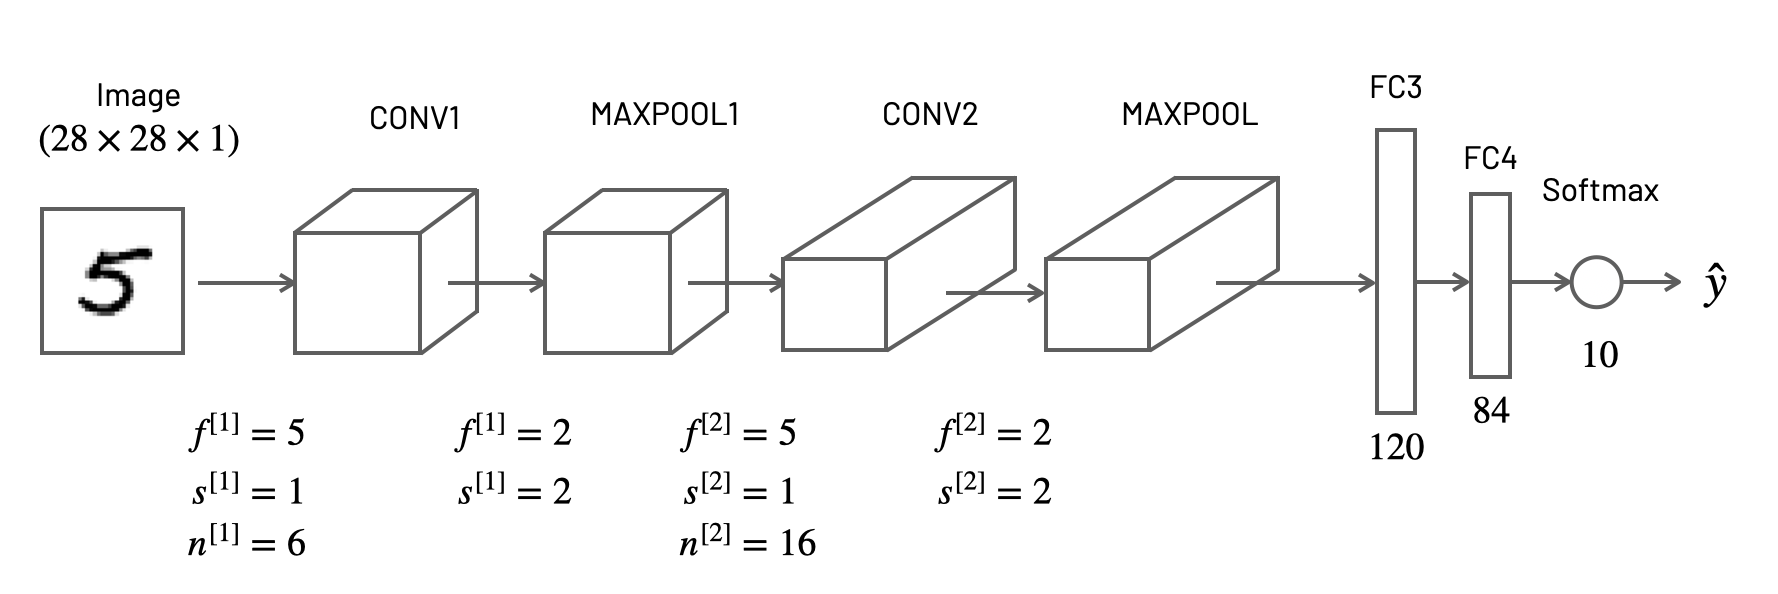


In [ ]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        """
        Initializes the LeNet-5 layers.
        f = kernel_size -> Filter size
        s = stride -> Stride/Tamanho do Passo
        n = out_channels -> Number of Filters
        """
        super(LeNet5, self).__init__()
        # CONV1
        self.conv1 = CustomConv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0)

        # MAXPOOL1
        self.max1 = CustomMaxPool2d(kernel_size=2, stride=2)

        #CONV2
        self.conv2 = CustomConv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)

        # MAXPOOL2
        self.max2 = CustomMaxPool2d(kernel_size=2, stride=2)

        self.fc1 = torch.nn.Linear(16 * 4 * 4, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)


    def forward(self, x):
        """
        Run the forward pass of the LeNet-5

        Args:
            x (torch.Tensor): mini-batch of size (batch_size, in_channels, in_height, in_width)

        Returns:
            torch.Tensor: logits (ouput of the last layer without softax) of size (batch_size, 10)
        """
        # CONV1
        x = torch.nn.functional.relu(self.conv1(x))

        # MAXPOOL1
        x = self.max1(x)

        # CONV2
        x = torch.nn.functional.relu(self.conv2(x))

        # MAXPOOL2
        x = self.max2(x)

        # Flat the output
        x = x.view(x.size(0), -1)

        # apply relu on fully connected layer 1
        x = torch.nn.functional.relu(self.fc1(x))

        # apply relu on fully connected layer 2
        x = torch.nn.functional.relu(self.fc2(x))

        # output layer
        x = self.fc3(x)

        return x


In [ ]:
# Set random seed
torch.manual_seed(42)

# Create an instance of your LeNet5 model
model = LeNet5()

# Select a single example from the test dataset
example_image, example_label = next(iter(test_loader))
example_image = example_image[0]  # Take the first image from the batch
example_label = example_label[0]

# Pass the example through the model
output = model(example_image.unsqueeze(0))  # Add a batch dimension

# Get the predicted class
predicted_class = torch.argmax(output).item()

# Print the results
print(f"Example Image Label: {example_label}")
print(f"Predicted Class: {predicted_class}")

# You can also print the output probabilities if needed
print(f"Output Probabilities: {torch.nn.functional.softmax(output, dim=1)}")

Example Image Label: 7
Predicted Class: 5
Output Probabilities: tensor([[4.4402e-06, 4.9075e-10, 2.3634e-02, 1.0730e-10, 1.3650e-07, 9.6639e-01,
         2.9831e-03, 9.2747e-04, 6.0459e-03, 1.3411e-05]],
       grad_fn=<SoftmaxBackward0>)


**Expected result:**
<table style="width:50%">
  <tr>
    <td>Example Image Label</td>
    <td>7</td>
  </tr>
  <tr>
    <td>Predicted Class</td>
    <td>5</td>
  </tr>
    <tr>
    <td>Output Probabilities</td>
    <td>[[4.4402e-06, 4.9075e-10, 2.3634e-02, 1.0730e-10, 1.3650e-07, 9.6639e-01, 2.9830e-03, 9.2747e-04, 6.0458e-03, 1.3411e-05]]</td>
  </tr>
</table>

## **Part 3: Training**

Now that you have your LeNet-5 defined, it's time to train it with mini-batch gradient descent. Fill out the `train` function above specifing an Adam [optimizer](https://pytorch.org/docs/stable/optim.html), a Categorical CrossEntropy [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions) (also called criterion). Then write the loop to iterate on the number of epochs and, inside the epochs loop, write the loop to iterate on the number of batches. In Pytorch, the dataloader is an iterator, so you can iterate on each mini-batch with `for (x_t,y_t) in train_loader`. For each batch:

1. Reset the gradients with the [torch.optim.Optimizer.zero_grad](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html).
2. Run forward pass for the current mini-batch $x^{t}$ to get the prediction $y^{t}$
3. Compute the loss with the `critetion` object
4. Run backward pass from the loss value computed in the previous step (3.)
5. Update the weights of the model with the [torch.optim.Optimizer.step](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html)
6. Print the average loss after each 100 mini-batches




In [ ]:
def train(model, train_loader, epochs=5, lr=0.001):
    """
    Train the model with the Adam optimizer on the training set

    Args:
      model (torch.nn.Module): the model to train
      train_loader (torch.utils.data.DataLoader): the training set
      epochs (int): number of epochs
      lr (float): learning rate

    Returns:
      losses (list) : list of average losses after every 100 batches
    """
    model.train()

    # Define Adam Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # Define Categorical Cross Entropy Loss
    criterion = torch.nn.CrossEntropyLoss()

    losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        i = 0
        for (x_t,y_t) in train_loader:
            i += 1
            # Reset the gradients
            optimizer.zero_grad()
            # Get the predictions
            y_hat = model(x_t)
            # Calculate Loss
            loss = criterion(y_hat, y_t)
            # Calculate gradients
            loss.backward()
            # Update de weights
            optimizer.step()
            # Sum the total loss
            running_loss += loss.item()

            if i % 100 == 0:
                average_loss = running_loss / 100
                # print(f"Epoch [{epoch + 1}/{epochs}], Batch [{i}], Loss: {average_loss:.4f}")
                losses.append(average_loss)
                running_loss = 0.0

    # Plot graph
    plt.plot(losses, label="Loss")
    plt.xlabel("Every 100 batches")
    plt.ylabel("Loss")
    plt.title("Learning Curve")
    plt.grid(True)
    plt.legend()
    plt.show()

    return losses

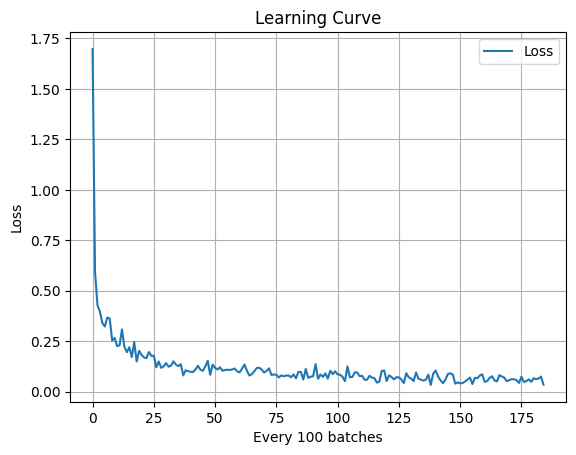

In [ ]:
# Set random seed
torch.manual_seed(42)

# Instantiate and train the model
model = LeNet5()
losses = train(model, train_loader, epochs=5)

**Expected result:**

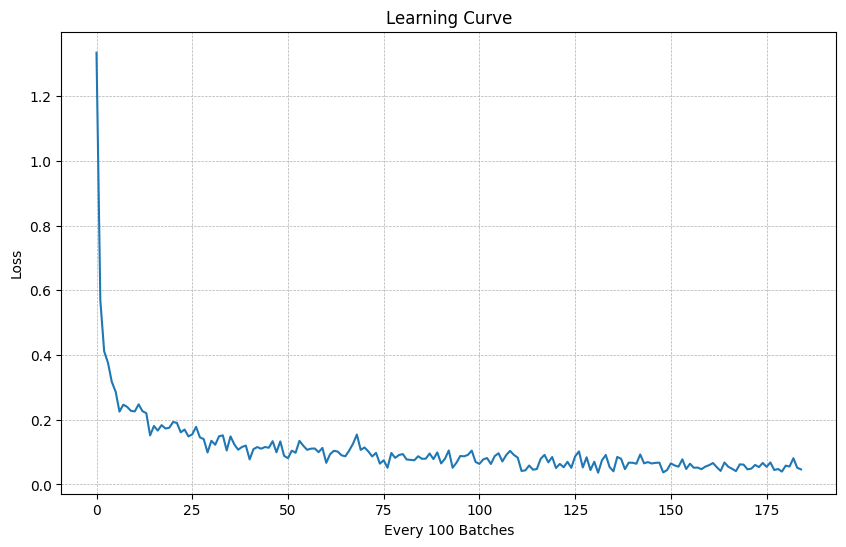

## **Part 4: Evaluation**

The last step is to evaluate your model. The MNIST is a balanced dataset and all classes have the same importance, so we can use accuracy for this task. Implement the following function to compute the accuracy of your LeNet-5 on the MNIST test set.

In [ ]:
def evaluate(model, test_loader):
    """
    Compute the accuracy of the model on the test set.

    Args:
        model (torch.nn.Module): The model to evaluate.
        test_loader (torch.utils.data.DataLoader): The data loader for the test set.

    Returns:
        float: The accuracy of the model on the test set.
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient
        for inputs, labels in test_loader:
            # Get the predictions
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            # Update the total and correct counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate accuracy
    accuracy = correct / total * 100

    return accuracy



In [ ]:
# Evaluate the model
accuracy = evaluate(model, test_loader)
print(f'Accuracy on test set: {accuracy:.2f}%')

Accuracy on test set: 97.91%


**Expected result:**
<table style="width:50%">
  <tr>
    <td>Accuracy on test set</td>
    <td>97.73%</td>
  </tr>
</table>

## **Part 5: Challenge (Optional)**

If you implemented your model correctly, it should have achieve a accuracy higher than 95%. Can you improve the network to do better? Write a model in PyTorch trying to improve the test accuracy. The best model will get an extra point! You can try any idea we've seen in the course so far, such as increasing the model, different pooling layers, regularization (L1, L2, Dropout), etc. Report the results of your model using the `evaluate` function above.

In [ ]:
class OptionalModel(torch.nn.Module):
    def __init__(self, padding = 0, bnorm2d = False, dropoutValue = 0):

        super(OptionalModel, self).__init__()

        # Init attributes
        self.padding = padding
        self.bnorm2d = bnorm2d
        self.dropoutValue = dropoutValue

        # CONV1
        self.conv1 = CustomConv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=padding)
        if bnorm2d:
          self.bn1 = torch.nn.BatchNorm2d(6)

        # MAXPOOL1
        self.max1 = CustomMaxPool2d(kernel_size=2, stride=2)

        #CONV2
        self.conv2 = CustomConv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=padding)
        if bnorm2d:
          self.bn2 = torch.nn.BatchNorm2d(16)

        # MAXPOOL2
        self.max2 = CustomMaxPool2d(kernel_size=2, stride=2)

        self.fc1 = torch.nn.Linear(16 * (4 + padding + 1) * (4 + padding + 1), 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)

        if dropoutValue != 0:
          self.dropout = torch.nn.Dropout(dropoutValue)

    def forward(self, x):
        """
        Run the forward pass of the LeNet-5

        Args:
            x (torch.Tensor): mini-batch of size (batch_size, in_channels, in_height, in_width)

        Returns:
            torch.Tensor: logits (ouput of the last layer without softax) of size (batch_size, 10)
        """
        # CONV1
        if self.bnorm2d:
          x = torch.nn.functional.relu(self.bn1(self.conv1(x))) # With BatchNorm2d
        else:
          x = torch.nn.functional.relu(self.conv1(x)) # Without BatchNorm2d

        # MAXPOOL1
        x = self.max1(x)

        # CONV2
        if self.bnorm2d:
          x = torch.nn.functional.relu(self.bn2(self.conv2(x))) # With BatchNorm2d
        else:
          x = torch.nn.functional.relu(self.conv2(x)) # Without BatchNorm2d

        # MAXPOOL2
        x = self.max2(x)

        # Flat the output
        x = x.view(x.size(0), -1)

        # apply relu on fully connected layer 1
        x = torch.nn.functional.relu(self.fc1(x))

        # Apply dropout if greater than 0
        if self.dropoutValue != 0:
          x = self.dropout(x)

        # apply relu on fully connected layer 2
        x = torch.nn.functional.relu(self.fc2(x))

        x = self.fc3(x)

        return x


In [ ]:
##### OptionalModel #####
# Set random seed
torch.manual_seed(42)

# Parameters
padding = 2
apply_batch_norm = True
dropoutValue = 0
epochs = 10
learning_rate = 0.0008


# Instantiate and train the model
model = OptionalModel(padding = padding, bnorm2d = apply_batch_norm, dropoutValue = dropoutValue)
losses = train(model, train_loader, epochs=epochs, lr=learning_rate)

In [ ]:
##### OptionalModel #####
# Evaluate the model
accuracy = evaluate(model, test_loader)
print(f'Accuracy on test set: {accuracy:.2f}%')

# Explaining the Optional Model

The model was progressively adjusted over 17 iterations, varying parameters such as BatchNorm2d, Dropout, Learning Rate, Padding, and Epochs. The main adjustments and their impacts are summarized below:

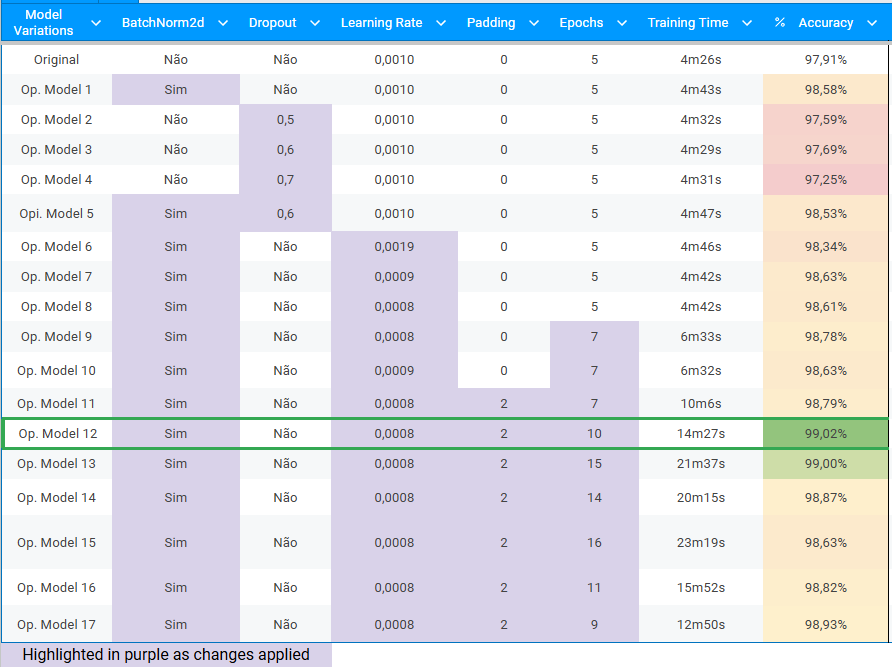

[Access the original table with comments](https://docs.google.com/spreadsheets/d/1QfDOJJ6IPmmiB4XYSCt5thmJDUs8ZDYqKdxmwpNBB98/edit?usp=sharing)


## Batch Normalization
Initially, the model did not use batch normalization. Starting from Op. Model 1, BatchNorm2d was applied, resulting in improved accuracy. This adjustment was retained in subsequent versions.

## Dropout
Dropout was tested at various levels (0.5, 0.6, 0.7) between Op. Model 2 and Op. Model 5. In all cases, Dropout decreased accuracy compared to the initial configuration and was therefore discarded in later iterations.

## Learning Rate
The original model used a learning rate of 0.001. In the Optional Model, the learning rate varied between 0.0019 and 0.0008 across different iterations. In Op. Model 6, increasing the rate to 0.0019 reduced accuracy, prompting tests with values lower than the initial rate. The rate of 0.0008 yielded the best results, particularly in Op. Model 12.

## Padding
Starting from Op. Model 11, padding of size 2 was added to maintain output dimensions, leading to a significant improvement in accuracy, reaching 98.79%.

## Epochs
The number of epochs was gradually increased, from 5 epochs to 16 epochs. Op. Model 12 with 10 epochs and padding achieved a significant gain, reaching 99.02% accuracy. Upon reaching the highest accuracies (Op. Model 12 and 13), validation was repeated with one epoch more and one less to confirm these as peak points; these boundary models did not surpass Op. Model 12's performance.

# Best Model
Op. Model 12 achieved the highest accuracy with 10 epochs, Batch Normalization, no dropout, a learning rate of 0.0008, and padding of size 2, establishing it as the optimal configuration in this experiment.